In [71]:
from simbad_download import resolve_name
import pandas as pd

from astropy.coordinates import ICRS, SkyCoord
import astropy.units as u

import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.optimize import minimize

In [72]:
KAPPA = 4.74047

In [73]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name('NGC 188')

In [76]:
sources = pd.read_csv('ngc 188 5d.csv')

In [77]:
len(sources)

301561

In [78]:
sources.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error
0,575922816240170368,42.067044,0.718274,87.526657,0.631198,0.440745,0.724745,0.608138,-1.037192,0.951654,3.024045,0.948973
1,575921205628441344,39.110251,0.033311,87.436855,0.027938,0.711382,0.031558,22.542192,2.641619,0.045092,4.007487,0.039009
2,575921308706406400,39.462327,0.567571,87.449999,0.471968,0.631252,0.562629,1.121969,3.403206,0.823528,1.344071,0.753207
3,575921476210326272,40.225136,0.087846,87.459656,0.073540,0.428389,0.094495,4.533451,0.542979,0.143017,6.791917,0.120112
4,575921510570062336,40.025703,0.118615,87.461371,0.101676,0.576776,0.118824,4.854045,0.713331,0.170573,6.121507,0.156338


In [79]:
sky_coords = SkyCoord(ra=sources['ra'].values,
                      dec=sources['dec'].values,
                      unit=(u.deg, u.deg),
                      frame=ICRS)

sources.ra = sky_coords.ra.wrap_at(180 * u.deg).value

In [80]:
coordinates = SkyCoord(ra=sources.ra.values*u.deg, dec=sources.dec.values*u.deg, 
                       distance=(1/sources.parallax.values)*u.kpc, radial_velocity=cp_radvel*u.km/u.s,
                       pm_ra_cosdec=sources.pmra.values*u.mas/u.yr, pm_dec=sources.pmdec.values*u.mas/u.yr,
                       frame=ICRS)

The corrections that can be applied to clusters more distant than the Hyades (van Leeuwen, 2009):

$\Delta\mu_{\alpha*, i}\approx-\frac{\varpi_i-\varpi_0}{\varpi_0}\mu_{\alpha*,0}+(\mu_{\alpha*,i}-\mu_{\alpha*,0})$

$\Delta\mu_{\delta, i}\approx-\frac{\varpi_i-\varpi_0}{\varpi_0}\mu_{\delta,0}+(\mu_{\delta,i}-\mu_{\delta,0})$

In [81]:
galactic_cartesian = coordinates.galactic.cartesian

In [82]:
def cp_proper_motions_corrections(parallax: np.array,
                                  cp_parallax: np.array,
                                  pmra: np.array,
                                  cp_pmra: np.array,
                                  pmdec: np.array,
                                  cp_pmdec) -> np.matrix:
    return np.array([(-(parallax-cp_parallax)/cp_parallax)*cp_pmra+(pmra-cp_pmra),
                     (-(parallax-cp_parallax)/cp_parallax)*cp_pmdec+(pmdec-cp_pmdec)]).T

In [83]:
cp_proper_motions_corrections([0.3, 0.5], cp_par, [-2.1, -2.1], cp_pmra, [-0.9, -0.9], cp_pmdec)

array([[-0.72930932, -0.33211953],
       [ 0.18448446,  0.04646745]])

In [84]:
proper_motion_corrections = cp_proper_motions_corrections(sources.parallax.values,
                                                          cp_par,
                                                          sources.pmra.values,
                                                          cp_pmra,
                                                          sources.pmdec.values,
                                                          cp_pmdec)

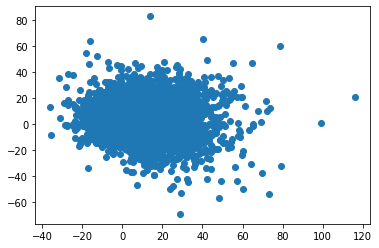

In [85]:
plt.scatter(proper_motion_corrections[:, 0], proper_motion_corrections[:, 1])

In [137]:
cluster_values = pd.DataFrame(data=np.array([
    galactic_cartesian.x.value,
    galactic_cartesian.y.value,
    galactic_cartesian.z.value,
    sources.pmra.values+proper_motion_corrections[:, 0],
    sources.pmdec.values+proper_motion_corrections[:, 1]
]).T, columns=['x', 'y', 'z', 'u_par', 'u_per'])

In [138]:
from scipy import stats

In [139]:
cluster_values.describe()

,x,y,z,u_par,u_per
count,301561.000000,301561.000000,301561.000000,301561.000000,301561.000000
mean,-1.143834,1.772945,0.839831,1.882030,2.559224
std,0.363206,0.549702,0.270168,8.893946,6.921900
min,-2.292589,0.961483,0.399264,-74.307657,-139.095823
25%,-1.384274,1.315781,0.625048,-2.965568,-0.764865
50%,-1.065109,1.652953,0.781458,0.870633,2.368554
75%,-0.846609,2.144768,1.011263,5.562359,5.639779
max,-0.568047,3.304153,1.824493,229.297278,165.066961


In [140]:
#cluster_values_q = cluster_values[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1)]

In [141]:
#sources_q = sources[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1).values]

In [142]:
scaler = StandardScaler()

s = scaler.fit_transform(cluster_values.values)

In [143]:
len(s)

301561

In [144]:
import matplotlib.pyplot as plt

bleh

In [145]:
from sklearn.cluster import DBSCAN

In [146]:
from_lit: pd.DataFrame = pd.read_csv('./data/ngc_188/literature.csv').drop(columns='Unnamed: 0')
from_lit.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
0,NGC 188 1054,303084,2004PASP..116.1012S,11.191250,85.256734,2020yCat.1350....0G,0.5409,0.0189,2020yCat.1350....0G,-2.178,...,3.0,2020yCat.1350....0G,-42.18,NaN,2008AJ....135.2264G,Gaia EDR3 573942325217383424|TIC 461601298|2MA...,573942325217383424,5.739423e+17,461601298.0,8
1,Cl* NGC 188 DGV 1869,303589,2004PASP..116.1012S,9.743203,85.559916,2020yCat.1350....0G,0.5191,0.0232,2020yCat.1350....0G,-2.250,...,3.0,2020yCat.1350....0G,-42.74,NaN,2008AJ....135.2264G,Gaia EDR3 573982010715088256|TIC 461597588|2MA...,573982010715088256,5.739820e+17,461597588.0,8
2,NGC 188 2014,303857,2004PASP..116.1012S,10.977598,85.205113,2020yCat.1350....0G,0.4785,0.0404,2020yCat.1350....0G,-2.368,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935899946338816|TIC 461599220|2MA...,573935899946338816,5.739359e+17,461599220.0,6
3,NGC 188 1152,303904,2004PASP..116.1012S,11.164145,85.242850,2020yCat.1350....0G,0.6603,0.0853,2020yCat.1350....0G,-2.111,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941942962994176|TIC 461601256|2MA...,573941942962994176,5.739419e+17,461601256.0,3
4,NGC 188 3129,303875,2004PASP..116.1012S,11.151445,85.352770,2020yCat.1350....0G,0.5443,0.0169,2020yCat.1350....0G,-2.387,...,3.0,2020yCat.1350....0G,-42.69,NaN,2008AJ....135.2264G,Gaia EDR3 573944215002950144|TIC 461601456|2MA...,573944215002950144,5.739442e+17,461601456.0,8


In [ ]:
dbscan_clust = DBSCAN(eps=.975, min_samples=5)
dbscan_fit = dbscan_clust.fit(s)

dbscan_labels = dbscan_fit.labels_
unique_labels = set(dbscan_labels)
print(f'Classified into {len(unique_labels)} labels: {unique_labels}')

print(dbscan_labels.shape)

sources['labels'] = dbscan_labels

In [ ]:
sources['labels'].value_counts()

In [179]:
def is_in_cluster_function(cluster_sources: pd.DataFrame,
                           source_id_col_name: str = 'source_id'):
    def is_in_cluster(source_id: int) -> bool:
        return len(cluster_sources[cluster_sources[source_id_col_name]==source_id]) > 0
    return is_in_cluster

In [180]:
is_in_edr3 = is_in_cluster_function(sources)
from_lit_edr3 = from_lit[np.vectorize(is_in_edr3)(from_lit['EDR3 id'].values)]

In [181]:
def check_for_cluster_children(from_lit: pd.DataFrame,
                               cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(cluster_sources)
    in_cluster = np.vectorize(is_in_cluster)(from_lit['EDR3 id'].values)
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return in_cluster

In [254]:
in_cluster = check_for_cluster_children(from_lit_edr3, sources[sources['labels']==557])

1110/1327 objects found in the cluster.


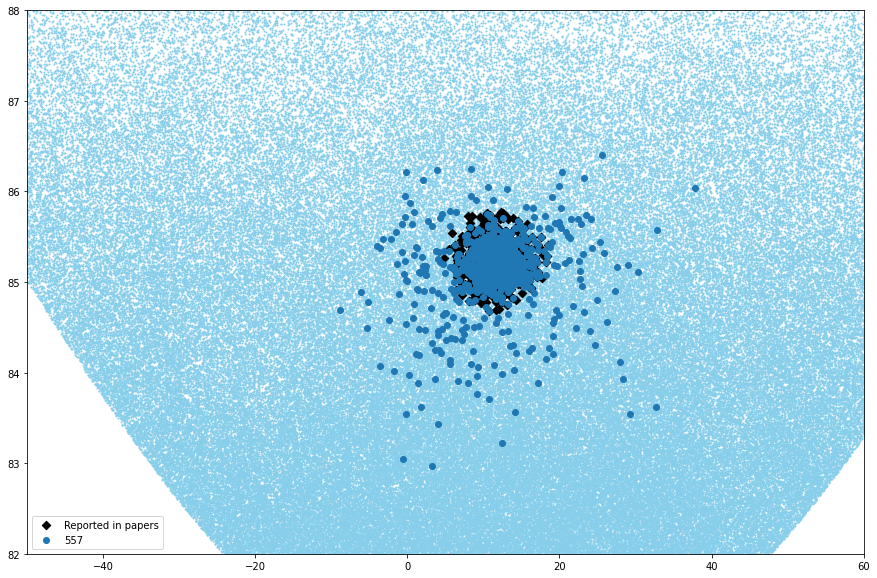

In [255]:
plt.figure(figsize=(15, 10))
plt.scatter(sources.ra, sources.dec, s=1, color='skyblue')
plt.scatter(from_lit_edr3.ra, from_lit_edr3.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
for ul in [557]:
    plt.scatter(sources[sources['labels']==ul].ra, sources[sources['labels']==ul].dec, label=ul)
plt.legend()
plt.gca().set_ylim(82, 88)
plt.gca().set_xlim(-50, 60);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


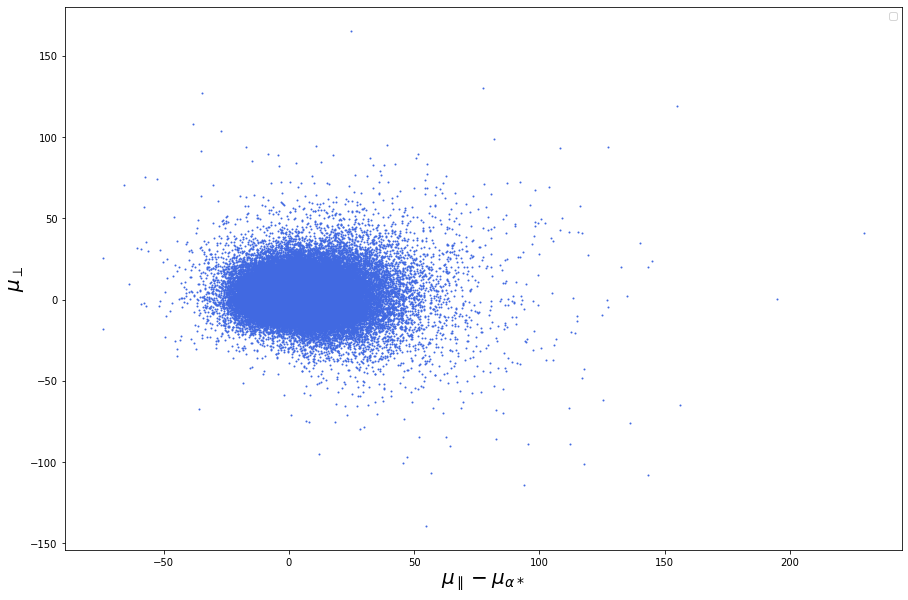

In [160]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.u_par, cluster_values.u_per, s=1, color='royalblue')
# for ul in [0]:
#     plt.scatter(cluster_values[sources['labels']==ul].u_par, cluster_values[sources['labels']==ul].u_per, label=ul)
plt.legend()
# plt.gca().set_xlim(-5, 5)
# plt.gca().set_ylim(-5, 5)
plt.gca().set_ylabel('$\mu_\perp$', fontsize=20);
plt.gca().set_xlabel('$\mu_\parallel-\mu_{\\alpha*}$', fontsize=20);

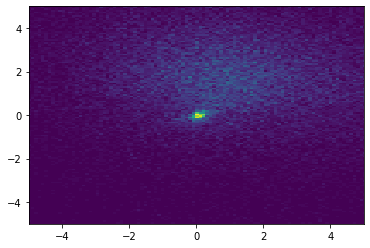

In [52]:
plt.hist2d(cluster_values.u_par, cluster_values.u_per, bins=1000);
plt.gca().set_xlim(-5, 5)
plt.gca().set_ylim(-5, 5);